In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import editdistance
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import simdna
from simdna import synthetic
import torch

from pyx.one_hot import one_hot
from tf_coop_model import CountsRegressor, IterablePandasDataset
from tf_coop_model import anscombe_transform, run_one_epoch, pearson_r, spearman_rho, rsquared
from tf_coop_simulation import background_frequency, simulate_oracle_predictions

%matplotlib inline

# Initialize Model & Load Weights
This step assumes we've trained a counts regression model and have its weights stored in a .pt[h] file somewhere accessible.

In [18]:
n_conv_layers = 3
n_dense_layers = 3
n_outputs = 2
sequence_length = 100
filters = 15
filter_width = 7
dense_layer_width = 30

no_variants_weights_fpath = '../dat/sim/cnn_counts_predictor_no_variants.pt'
variants_weights_fpath = '../dat/sim/cnn_counts_predictor_with_variants.pt'

test_data_fpath = '../dat/sim/test_labels.csv'
test_variants_data_fpath = '../dat/sim/test_variant_labels.csv'
raw_simulation_data_fpath = '../dat/sim/test_sequences.simdata'

exposure_motif = "GATA_disc1"
outcome_motif = "TAL1_known1"

sequences_col = "sequences"
label_cols = ["labels_exp", "labels_out"]
batch_size = 1000

In [19]:
variants_model = CountsRegressor(n_conv_layers,
    n_dense_layers,
    n_outputs,
    sequence_length,
    filters,
    filter_width,
    dense_layer_width
)
variants_model.load_state_dict(torch.load(variants_weights_fpath))
variants_model

CountsRegressor(
  (conv_layers): Sequential(
    (0): Conv1d(4, 15, kernel_size=(7,), stride=(1,))
    (1): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(15, 15, kernel_size=(7,), stride=(1,))
    (4): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(15, 15, kernel_size=(7,), stride=(1,))
    (7): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (dense_layers): Sequential(
    (0): Flatten()
    (1): Linear(in_features=1230, out_features=30, bias=True)
    (2): ReLU()
    (3): Linear(in_features=30, out_features=30, bias=True)
    (4): ReLU()
    (5): Linear(in_features=30, out_features=30, bias=True)
    (6): ReLU()
  )
  (regressor): Linear(in_features=30, out_features=2, bias=True)
)

In [20]:
no_variants_model = variants_model
# CountsRegressor(n_conv_layers,
#     n_dense_layers,
#     n_outputs,
#     sequence_length,
#     filters,
#     filter_width,
#     dense_layer_width
# )
# no_variants_model.load_state_dict(torch.load(no_variants_weights_fpath))
# no_variants_model

# Load Test Data & Generate Predictions
Now we're going to load test data to get some basic metrics about how well our model performs. We'll later use these numbers to test whether the model maintains its performance when predicting counts for test set variants.

In [31]:
test_df = pd.read_csv(test_data_fpath)
test_df = test_df[(test_df['has_exposure'] == 1) & (test_df['has_outcome'] == 1)]

test_dataset = IterablePandasDataset(
    test_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
    y_transform=anscombe_transform,
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=0
)

In [32]:
variants_predictions, _, variants_metrics = run_one_epoch(
    variants_model, test_data_loader, None, training=False, metrics_config={
        "spearman-rho": spearman_rho,
        "r-squared": rsquared,
        "pearson-r": pearson_r,
    }
)
no_variants_predictions, _, no_variants_metrics = run_one_epoch(
    no_variants_model, test_data_loader, None, training=False, metrics_config={
        "spearman-rho": spearman_rho,
        "r-squared": rsquared,
        "pearson-r": pearson_r,
    }
)
print("Variants Model Metrics: ", variants_metrics)
print("No Variants Model Metrics: ", no_variants_metrics)

Variants Model Metrics:  {'spearman-rho': [0.025104503491980085, 0.020377237505026822], 'r-squared': array([-6.78802581, -6.19693723]), 'pearson-r': [0.02108692610339403, 0.018394230309817166]}
No Variants Model Metrics:  {'spearman-rho': [0.025104503491980085, 0.020377237505026822], 'r-squared': array([-6.78802581, -6.19693723]), 'pearson-r': [0.02108692610339403, 0.018394230309817166]}


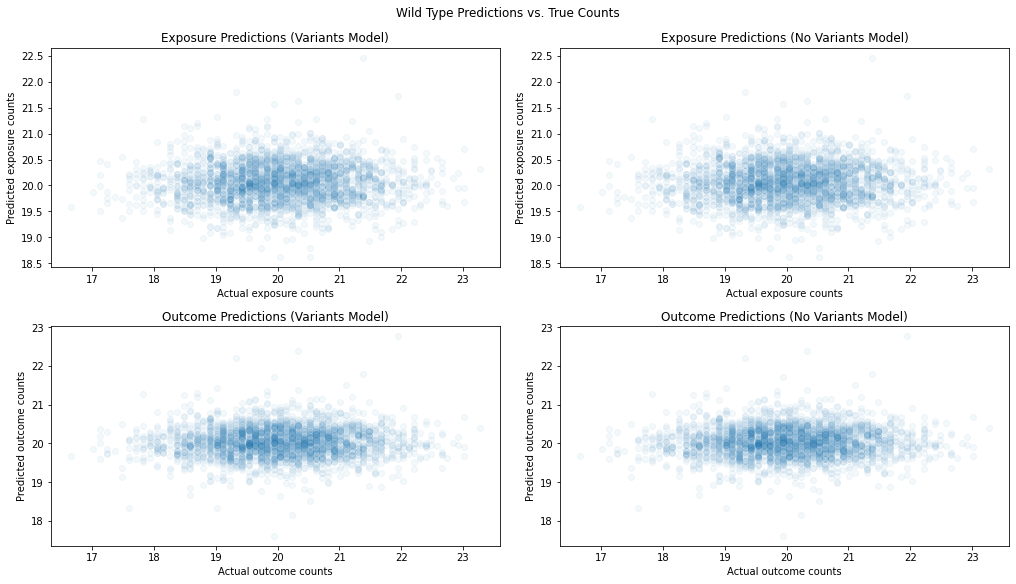

In [33]:
test_exp_labels = [l[0] for _, l in test_dataset]
test_out_labels = np.array([l[1] for _, l in test_dataset])

fig, axs = plt.subplots(2, 2, figsize=(14, 8), constrained_layout=True)

fig.suptitle("Wild Type Predictions vs. True Counts")

axs[0, 0].scatter(test_exp_labels, np.array(variants_predictions)[:, 0], alpha=0.05)
axs[0, 0].set_title("Exposure Predictions (Variants Model)")
axs[0, 0].set_xlabel("Actual exposure counts")
axs[0, 0].set_ylabel("Predicted exposure counts")

axs[0, 1].scatter(test_exp_labels, np.array(no_variants_predictions)[:, 0], alpha=0.05)
axs[0, 1].set_title("Exposure Predictions (No Variants Model)")
axs[0, 1].set_xlabel("Actual exposure counts")
axs[0, 1].set_ylabel("Predicted exposure counts")

axs[1, 0].scatter(test_exp_labels, np.array(variants_predictions)[:, 1], alpha=0.05)
axs[1, 0].set_title("Outcome Predictions (Variants Model)")
axs[1, 0].set_xlabel("Actual outcome counts")
axs[1, 0].set_ylabel("Predicted outcome counts")

axs[1, 1].scatter(test_exp_labels, np.array(no_variants_predictions)[:, 1], alpha=0.05)
axs[1, 1].set_title("Outcome Predictions (No Variants Model)")
axs[1, 1].set_xlabel("Actual outcome counts")
axs[1, 1].set_ylabel("Predicted outcome counts");

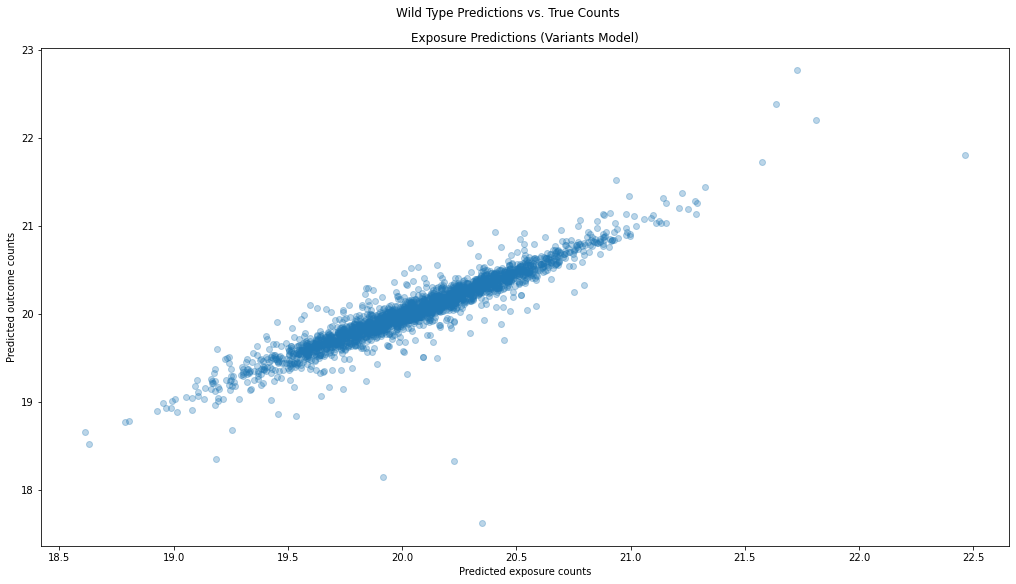

In [38]:
test_exp_labels = [l[0] for _, l in test_dataset]
test_out_labels = np.array([l[1] for _, l in test_dataset])

fig, axs = plt.subplots(1, 1, figsize=(14, 8), constrained_layout=True)

fig.suptitle("Wild Type Predictions vs. True Counts")

axs.scatter(np.array(variants_predictions)[:, 0], np.array(variants_predictions)[:, 1], alpha=0.3)
axs.set_title("Exposure Predictions (Variants Model)")
axs.set_xlabel("Predicted exposure counts")
axs.set_ylabel("Predicted outcome counts");

# Variant effect prediction quality

In [34]:
test_variants_df = pd.read_csv(test_variants_data_fpath)
filtered_test_variants_df = test_variants_df[
#     (test_variants_df['has_exposure'] == 1) 
#     (test_variants_df['has_outcome'] == 1) |
    (test_variants_df['has_both'] == 1)
].reset_index()

original_variant_rows = test_df.iloc[filtered_test_variants_df['original_index'], :].reset_index().copy()
original_variant_rows = original_variant_rows.rename(
    columns={'labels_exp': 'original_labels_exp', 'labels_out': 'original_labels_out'}
)

for i in range(5):
    variant, wild_type = filtered_test_variants_df.sequences.values[i], original_variant_rows.sequences.values[i]
    assert editdistance.eval(variant, wild_type) in [1, 2], editdistance.eval(variant, wild_type)

original_variant_rows = original_variant_rows.drop(columns=["sequences"])
variants_df = pd.concat((filtered_test_variants_df, original_variant_rows), axis=1)

variants_df.head()

IndexError: positional indexers are out-of-bounds

In [ ]:
variants_test_dataset = IterablePandasDataset(
    variants_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot, y_transform=anscombe_transform
)
variants_test_data_loader = torch.utils.data.DataLoader(
    variants_test_dataset, batch_size=batch_size, num_workers=0
)

In [ ]:
variants_variant_predictions, _, variants_variant_metrics = run_one_epoch(
    variants_model, variants_test_data_loader, None, training=False, metrics_config={
        "spearman-rho": spearman_rho,
        "r-squared": rsquared,
        "pearson-r": pearson_r,
    }
)
no_variants_variant_predictions, losses, no_variants_variant_metrics = run_one_epoch(
    no_variants_model, variants_test_data_loader, None, training=False, metrics_config={
        "spearman-rho": spearman_rho,
        "r-squared": rsquared,
        "pearson-r": pearson_r,
    }
)

In [ ]:
test_exp_labels = np.array([l[0] for _, l in variants_test_dataset])
test_out_labels = np.array([l[1] for _, l in variants_test_dataset])

fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

fig.suptitle("Variant Predictions vs. True Counts")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

ax = axs[0, 0]
counts, pred_counts = test_exp_labels, np.array(variants_variant_predictions)[:, 0]
ax.scatter(counts, pred_counts, alpha=0.1)
ax.set_title("Exposure Counts (Variants Model)")
ax.set_xlabel("Actual Exposure Count")
ax.set_ylabel("Predicted Exposure Count")
metrics_str = '\n'.join((
    r'$ R^2 = %.3f $' % (rsquared(counts, pred_counts)),
    r'$ \rho = %.3f $' % (spearman_rho(counts, pred_counts)),
))
ax.text(
    0.05, 0.95, metrics_str, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props
)

ax = axs[0, 1]
counts, pred_counts = test_exp_labels, np.array(no_variants_variant_predictions)[:, 0]
ax.scatter(counts, pred_counts, alpha=0.1)
ax.set_title("Exposure Counts (No Variants Model)")
ax.set_xlabel("Actual Exposure Count")
ax.set_ylabel("Predicted Exposure Count")
metrics_str = '\n'.join((
    r'$ R^2 = %.3f $' % (rsquared(counts, pred_counts)),
    r'$ \rho = %.3f $' % (spearman_rho(counts, pred_counts)),
))
ax.text(
    0.05, 0.95, metrics_str, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props
)

ax = axs[1, 0]
counts, pred_counts = test_out_labels, np.array(variants_variant_predictions)[:, 1]
ax.scatter(counts, pred_counts, alpha=0.1)
ax.set_title("Outcome Variants (Variants Model)")
ax.set_xlabel("Actual Outcome Variant")
ax.set_ylabel("Predicted Outcome Variant")
metrics_str = '\n'.join((
    r'$ R^2 = %.3f $' % (rsquared(counts, pred_counts)),
    r'$ \rho = %.3f $' % (spearman_rho(counts, pred_counts)),
))
ax.text(
    0.05, 0.95, metrics_str, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props
)

ax = axs[1, 1]
counts, pred_counts = test_out_labels, np.array(no_variants_variant_predictions)[:, 1]
ax.scatter(counts, pred_counts, alpha=0.1)
ax.set_title("Outcome Variants (No Variants Model)")
ax.set_xlabel("Actual Outcome Variant")
ax.set_ylabel("Predicted Outcome Variant")
metrics_str = '\n'.join((
    r'$ R^2 = %.3f $' % (rsquared(counts, pred_counts)),
    r'$ \rho = %.3f $' % (spearman_rho(counts, pred_counts)),
))
ax.text(
    0.05, 0.95, metrics_str, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props
)

In [ ]:
real_exp_variant_effects = (
    anscombe_transform(variants_df['labels_exp']) - anscombe_transform(variants_df['original_labels_exp'])
)
real_out_variant_effects = (
    anscombe_transform(variants_df['labels_out']) - anscombe_transform(variants_df['original_labels_out'])
)
original_variants_variant_predictions = [variants_predictions[i] for i in variants_df['original_index']]
variants_predicted_variant_effects = (
    np.array(variants_variant_predictions) - np.array(original_variants_variant_predictions)
)

original_no_variants_variant_predictions = [no_variants_predictions[i] for i in variants_df['original_index']]
no_variants_predicted_variant_effects = (
    np.array(no_variants_variant_predictions) - np.array(original_no_variants_variant_predictions)
)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

fig.suptitle("Variant Effect Predictions vs. True Variant Effects")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

ax = axs[0, 0]
veffs, pred_veffs = real_exp_variant_effects, variants_predicted_variant_effects[:, 0]
ax.scatter(veffs, pred_veffs, alpha=0.1)
ax.set_title("Exposure Variant Effects (Variants Model)")
ax.set_xlabel("Actual Exposure Variant Effect")
ax.set_ylabel("Predicted Exposure Variant Effect")
metrics_str = '\n'.join((
    r'$ R^2 = %.3f $' % (rsquared(veffs, pred_veffs)),
    r'$ \rho = %.3f $' % (spearman_rho(veffs, pred_veffs)),
))
ax.text(
    0.05, 0.95, metrics_str, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props
)

ax = axs[0, 1]
veffs, pred_veffs = real_exp_variant_effects, no_variants_predicted_variant_effects[:, 0]
ax.scatter(veffs, pred_veffs, alpha=0.1)
ax.set_title("Exposure Variant Effects (No Variants Model)")
ax.set_xlabel("Actual Exposure Variant Effect")
ax.set_ylabel("Predicted Exposure Variant Effect")
metrics_str = '\n'.join((
    r'$ R^2 = %.3f $' % (rsquared(veffs, pred_veffs)),
    r'$ \rho = %.3f $' % (spearman_rho(veffs, pred_veffs)),
))
ax.text(
    0.05, 0.95, metrics_str, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props
)

ax = axs[1, 0]
veffs, pred_veffs = real_out_variant_effects, variants_predicted_variant_effects[:, 1]
ax.scatter(veffs, pred_veffs, alpha=0.1)
ax.set_title("Outcome Variant Effects (Variants Model)")
ax.set_xlabel("Actual Outcome Variant Effect")
ax.set_ylabel("Predicted Outcome Variant Effect")
metrics_str = '\n'.join((
    r'$ R^2 = %.3f $' % (rsquared(veffs, pred_veffs)),
    r'$ \rho = %.3f $' % (spearman_rho(veffs, pred_veffs)),
))
ax.text(
    0.05, 0.95, metrics_str, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props
)

ax = axs[1, 1]
veffs, pred_veffs = real_out_variant_effects, no_variants_predicted_variant_effects[:, 1]
ax.scatter(veffs, pred_veffs, alpha=0.1)
ax.set_title("Outcome Variant Effects (No Variants Model)")
ax.set_xlabel("Actual Outcome Variant Effect")
ax.set_ylabel("Predicted Outcome Variant Effect")
metrics_str = '\n'.join((
    r'$ R^2 = %.3f $' % (rsquared(veffs, pred_veffs)),
    r'$ \rho = %.3f $' % (spearman_rho(veffs, pred_veffs)),
))
ax.text(
    0.05, 0.95, metrics_str, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props
)